In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
import pycce as pc
import ase

import warnings

from mpl_toolkits import mplot3d

from qutip import *

from ase.build import bulk

import pycce.filter

import scipy.stats as stats
from scipy.optimize import curve_fit

C:\Users\Daniel Low\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\Daniel Low\Anaconda3\lib\site-packages\qutip\__init__.py:61: UserWarning: Old version of Cython detected: needed 0.29.20, got 0.29.12.
  .format(_cy_require, _Cython.__version__)


In [3]:
import matplotlib as mpl  
plt.style.use('plot_style.txt')
# mpl.rcParams['figure.figsize'] = [12.0, 8.0]
# mpl.rcParams['xtick.labelsize'] = 15


Bad key "axes.titlelocation" on line 28 in
plot_style.txt.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
"""set up seed for T2 calculation of varying concentration"""
seed = 8805
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

In [19]:


# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]

# Add types of isotopes
diamond.add_isotopes(('13C', 0.0))
diamond.isotopes['C']['14C'] = 0.00

# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(100, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]))

atoms['14C'].gyro = 0
atoms['14C'].spin = 0

"setup for coherence calculation"

# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 180  # in A
# Cluster cutoff radius
r_dipole = 50  # in A

# position of central spin
position = [0,0,0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)



# electrons.from_point_dipole([0,0,70])

# Setting the runner engine
# mock = pc.Simulator(spin=nv,
#                     bath=np.concatenate([atoms,hydrogen]), r_bath=r_bath,
#                     r_dipole=r_dipole, order=order)

# calc = pc.Simulator(spin=nv, position=position, alpha=alpha, beta=beta,
#                     bath=electrons, r_bath=r_bath, magnetic_field=500, pulses=1,
#                     r_dipole=r_dipole, order=order)

# "scatter plot of points"

# # add 3D axis
# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(projection='3d')

# # We want to visualize the smaller bath
# data = mock.bath

# # First plot the positions of the bath
# colors = np.abs(data.A[:,2,2]/data.A[:,2,2].max())
# ax.scatter3D(data.x, data.y, data.z, c=colors, cmap='viridis');
# # Plot all pairs of nuclear spins, which are contained
# # in the calc.clusters dictionary under they key 2
# for c in mock.clusters[2]:
#     ax.plot3D(data.x[c], data.y[c], data.z[c], color='grey')
# # Plot all triplets of nuclear spins, which are contained
# # in the calc.clusters dictionary under they key 3
# for c in mock.clusters[3]:
#     ax.plot3D(data.x[c], data.y[c], data.z[c], color='red', ls='--', lw=0.5)

# ax.set(xlabel='x (A)', ylabel='y (A)', zlabel='z (A)');

### n = 20

In [16]:
oxygen = pc.random_bath('16O', [100, 100, 10], density=1e19,
                        density_units='cm-3', center=[50,50,70], seed=seed)

print(oxygen)

oxygen.zdir = [1,1,1]

[('16O', [ -6.55009, -29.31901, -68.64636], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])]


In [20]:
# Setting the runner engine
calc = pc.Simulator(spin=nv,
                    bath=np.concatenate([atoms,oxygen]), r_bath=r_bath,
                    r_dipole=r_dipole, order=order)



''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"coherence calculation"


"conventional"
# Time points
time_space = np.linspace(0, 2, 101)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0,0,500])  # in G

l_conv = calc.compute(time_space, pulses=n, magnetic_field=b, 
                      method='cce', quantity='coherence', as_delay=False)

"general"
# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function
l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')

"random sampling of bath states"
# Number of random bath states to sample over
n_bath_states = 40

# Calculate coherence function
l_gcce = calc.compute(time_space, magnetic_field=b,
                      pulses=pulse_sequence,
                      nbstates=n_bath_states,
                      method='gcce', quantity='coherence')


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


"fitting a negative squared exponential"


def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit

#popt: Optimized parameters
#pcov: matrix of covariance.
popt1,pcov1 = curve_fit(coherence_fit,time_space, l_generatilze.real)
popt2,pcov2 = curve_fit(coherence_fit,time_space, l_gcce.real)

print ("popt_gen :\n", popt1)
print ("pcov_gen :\n", pcov1)

print ("popt_samp :\n", popt2)
print ("pcov_samp :\n", pcov2)

T2_gen = popt1
T2_samp = popt2

y_gen = coherence_fit(time_space, T2_gen)   # calculates the y value using the Gaussian function
y_samp = coherence_fit(time_space, T2_samp)



C:\Users\Daniel Low\Anaconda3\lib\site-packages\pycce\bath\array.py:227: UserWarning: Spin type for 16O was not provided and was not found in common isotopes.
  obj['N'] = np.asarray(names).reshape(-1)


KeyError: 'Spin type for 16O was not provided and was not found in common isotopes.'

Text(0, 0.5, 'Coherence')

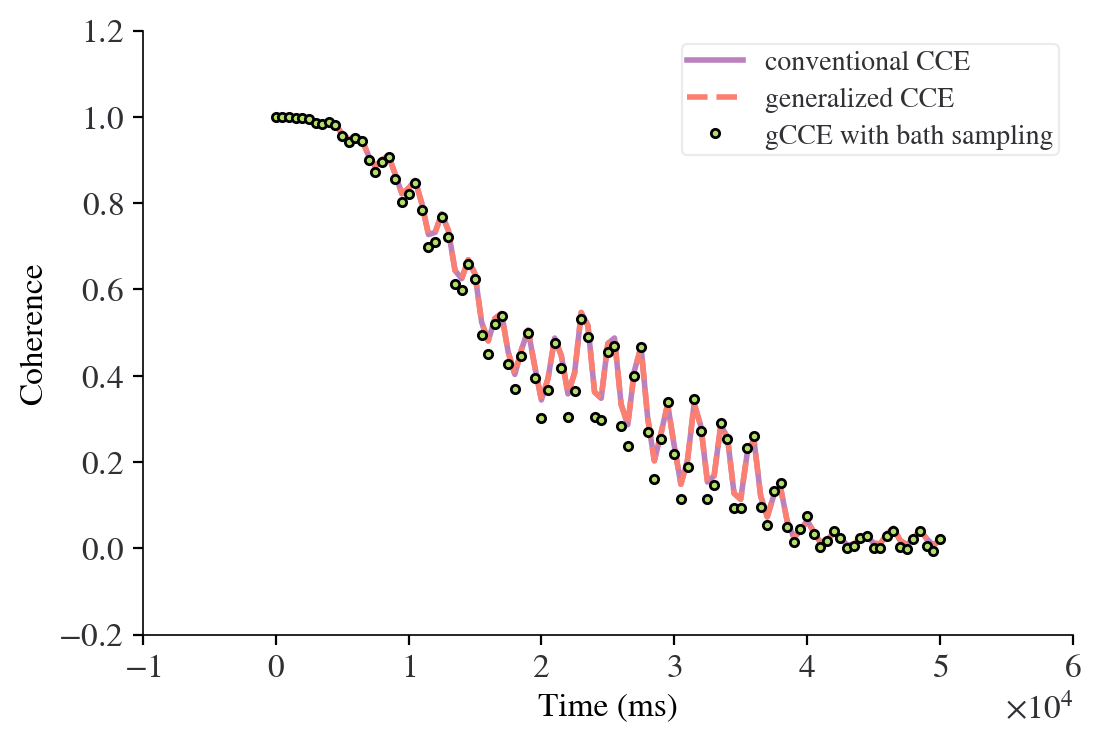

In [7]:
# plots the data points and the fitted Gaussian curve
plt.figure()

plt.plot(time_space, l_conv.real,
         label='conventional CCE')
plt.plot(time_space, l_generatilze.real,
         label='generalized CCE', ls='--')
plt.plot(time_space, l_gcce.real,
         label='gCCE with bath sampling', ls='', marker='.')


# plt.plot(time_space,y_gen,'-', label='fitted line for general')
# plt.plot(time_space,y_samp,'-', label='fitted line for sampling')

plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')
# plt.yscale('log')
#plt.title("fitted line to the calculated coherence decay")


### n = 200

In [1]:
oxygen = pc.random_bath('17O', [1e3, 1e3, 10], density=1e19,
                        density_units='cm-3', center=[500,500,70], seed=seed)

print(oxygen.size)

# oxygen.zdir = [1,1,1]

NameError: name 'pc' is not defined

In [9]:
# Setting the runner engine
calc = pc.Simulator(spin=nv,
                    bath=np.concatenate([atoms,oxygen]), r_bath=r_bath,
                    r_dipole=r_dipole, order=order)



''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"coherence calculation"


"conventional"
# Time points
time_space = np.linspace(0, 100000, 101)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0,0,500])  # in G

l_conv = calc.compute(time_space, pulses=n, magnetic_field=b, 
                      method='cce', quantity='coherence', as_delay=False)

"general"
# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function
l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')

"random sampling of bath states"
# Number of random bath states to sample over
n_bath_states = 40

# Calculate coherence function
l_gcce = calc.compute(time_space, magnetic_field=b,
                      pulses=pulse_sequence,
                      nbstates=n_bath_states,
                      method='gcce', quantity='coherence')


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


"fitting a negative squared exponential"


def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit

#popt: Optimized parameters
#pcov: matrix of covariance.
popt1,pcov1 = curve_fit(coherence_fit,time_space, l_generatilze.real)
popt2,pcov2 = curve_fit(coherence_fit,time_space, l_gcce.real)

print ("popt_gen :\n", popt1)
print ("pcov_gen :\n", pcov1)

print ("popt_samp :\n", popt2)
print ("pcov_samp :\n", pcov2)

T2_gen = popt1
T2_samp = popt2

y_gen = coherence_fit(time_space, T2_gen)   # calculates the y value using the Gaussian function
y_samp = coherence_fit(time_space, T2_samp)



LinAlgError: Eigenvalues did not converge

In [ ]:
# plots the data points and the fitted Gaussian curve
plt.figure()

plt.plot(time_space, l_conv.real,
         label='conventional CCE')
plt.plot(time_space, l_generatilze.real,
         label='generalized CCE', ls='--')
plt.plot(time_space, l_gcce.real,
         label='gCCE with bath sampling', ls='', marker='.')


# plt.plot(time_space,y_gen,'-', label='fitted line for general')
# plt.plot(time_space,y_samp,'-', label='fitted line for sampling')

plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')
# plt.yscale('log')
#plt.title("fitted line to the calculated coherence decay")
